In [26]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [27]:
import os
import numpy as np
import tensorflow as tf
import h5py
import math

def load_dataset():
    train_dataset = h5py.File(r'C:\Users\harla\Desktop\Jupyter Notebooks\ResNet\Dataset\signs\train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(r'C:\Users\harla\Desktop\Jupyter Notebooks\ResNet\Dataset\signs\test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


# Identity block 

In this block, input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). Here is a diagram illustrating how this works:

<img src="files\images\idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 2 layers. </center></caption>

The upper path is the shortcut path through which the activation in the previous layers "skips" through and is added and is added to the output of the main path before the non-linearity computation. 

Here, I have performed skipping over 3 hidden layers rather than just 2 which is described in the figure below. 
<img src="files\images\idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 3 layers. </center></caption>

In [3]:
# Implementation of Identity Block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
        
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b',kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1) ,padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
   
    
    return X

# Convolution Block

This block is different from the identity block in the sense that in shotcut step, convolution is used. This is to map the inout of the block to have same dimension as the output of the block, so that the two can be added, before applying the non-linearity step. The figure below explains how this block works. 

<img src="files\images\convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 3** </u><font color='purple'>  : **Convolutional block** </center></caption>
    

In [4]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', kernel_initializer = glorot_uniform(), padding="same")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform())(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

# ResNet 50

In this part, multiple identity and convolutional blocks have been implemented to map the architecture of ResNet50. The figure below shows how this assembly has been carried out. 

<img src="files\images\resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **ResNet-50 model** </center></caption>

In [5]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X,f=3, filters = [128, 128, 512], stage = 3, block = 'a', s =2)
    X = identity_block(X,3,[128, 128, 512], stage = 3, block = 'b')
    X = identity_block(X,3,[128,128,512], stage = 3, block = 'c')
    X = identity_block(X,3,[128,128,512], stage = 3, block = 'd')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X,f=3, filters = [256, 256, 1024], stage = 4, block = 'a', s =2)
    X = identity_block(X,3,[256, 256, 1024], stage = 4, block = 'b')
    X = identity_block(X,3,[256, 256, 1024], stage = 4, block = 'c')
    X = identity_block(X,3,[256, 256, 1024], stage = 4, block = 'd')
    X = identity_block(X,3,[256, 256, 1024], stage = 4, block = 'e')
    X = identity_block(X,3,[256, 256, 1024], stage = 4, block = 'f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X,f=3, filters = [512, 512, 2048], stage = 5, block = 'a', s =2) 
    X = identity_block(X,3,[512, 512, 2048], stage = 5, block = 'b')
    X = identity_block(X,3,[512, 512, 2048], stage = 5, block = 'c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2))(X)
    
    ### END CODE HERE ###

    # FC1 layer
    X = Flatten()(X)
    X = Dense(512,name = 'fc1')(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)
    
    # FC2 layer
    X = Flatten()(X)
    X = Dense(128,name = 'fc2')(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)
    
    # Output layer
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [6]:
model = ResNet50(input_shape = (64,64, 3), classes = 6)   # This dimension depends on input

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
x_train, y_train, x_test, y_test, classes = load_dataset()
y_train = y_train.T
y_test = y_test.T

In [8]:
# Print shape of training and test datasets
print('Shape of training set :' ,x_train.shape)
print('shape of test set :', x_test.shape )
print('shape of training_labels:', y_train.shape)
print('shape of test labels:', y_test.shape)
print('Number of training samples = ', x_train.shape[0])
print('Number of test samples = ', x_test.shape[0])

Shape of training set : (1080, 64, 64, 3)
shape of test set : (120, 64, 64, 3)
shape of training_labels: (1080, 1)
shape of test labels: (120, 1)
Number of training samples =  1080
Number of test samples =  120


In [9]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

This image is of class:  [2]


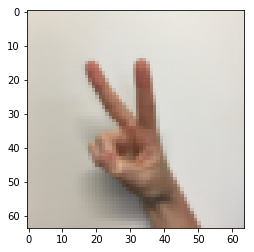

In [10]:
# Visualize  training set 
training_sample = 4;                # Change this to any value between 0 to 49999 and see how different training images look like
myImage = x_train[training_sample,:,:,:];
imshow(myImage)
print('This image is of class: ' , y_train[training_sample])

In [11]:
# Normalizing the train and test set
x_train = x_train/255;
x_test = (x_test)/255;
# Subtracting pixel mean
#subtract_pixel_mean = True

#if subtract_pixel_mean:
 #   x_train_mean = np.mean(x_train, axis=0)
  #  x_train -= x_train_mean
   # x_test -= x_train_mean

In [12]:
model.fit(x = x_train, y = y_train, verbose = 1, validation_split = 0.2, epochs = 20, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Train on 864 samples, validate on 216 samples
Epoch 1/20
864/864 [==============================] - 123s 143ms/step - loss: 2.6543 - acc: 0.3530 - val_loss: 1.0845 - val_acc: 0.5787
Epoch 2/20
864/864 [==============================] - 109s 126ms/step - loss: 0.8272 - acc: 0.6921 - val_loss: 0.7353 - val_acc: 0.7685
Epoch 3/20
864/864 [==============================] - 115s 133ms/step - loss: 0.5125 - acc: 0.8264 - val_loss: 0.9048 - val_acc: 0.7685
Epoch 4/20
864/864 [==============================] - 110s 128ms/step - loss: 0.4077 - acc: 0.8715 - val_loss: 0.4725 - val_acc: 0.8796
Epoch 5/20
864/864 [==============================] - 107s 124ms/step - loss: 0.1733 - acc: 0.9421 - val_loss: 0.7643 - val_acc: 0.8102
Epoch 6/20
864/864 [==============================] - 110s 127ms/step - loss: 0.2156 - acc: 0.9410 - val_loss: 0.7101 - val_acc: 0.8611
Epoch 7/20
864/864 [==============================] - 108s 125ms/step - loss: 0.3576 - acc

In [13]:
scores = model.evaluate(x_test,y_test)

120/120 [==============================] - 2s 20ms/step


In [14]:
print('Loss on test set is: ', scores[0])
print('Accuracy on test set is: ', scores[1])

Loss on test set is:  0.2492149790128072
Accuracy on test set is:  0.949999996026357


[[0.00470322 0.73543936 0.1079357  0.03907827 0.10078382 0.01205959]]
predicted sign is: 1
actual sign is:  [1]


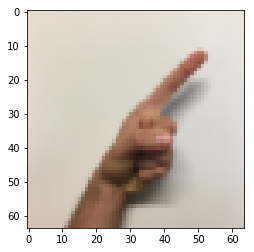

In [28]:
test_sample = 9
x = x_test[test_sample,:,:,:]
imshow(x)
x = np.expand_dims(x,axis = 0)
print(model.predict(x))
print('predicted sign is:', np.argmax(model.predict(x)))
print('actual sign is: ', y_test[test_sample])